In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.sparse import csr_matrix

In [2]:
# Show all replay data folders we saved using data_extraction.py
# The name of replay data folder is the exact replay name plus player perspective in the game
replay_data_path = './replay_data'
replay_list = os.listdir(replay_data_path)
replay_list

['Simple64_2017-12-22-18-33-05.SC2Replayplayer_1']

In [3]:
# Show contents in replay data folder
data = pd.DataFrame()
for i in replay_list:
    data[i] = os.listdir(replay_data_path + '/' + str(i))
data

,Simple64_2017-12-22-18-33-05.SC2Replayplayer_1
0,action.txt
1,available_actions.txt
2,build_queue.txt
3,cargo.txt
4,cargo_slots_available.txt
5,control_groups.txt
6,game_loop.txt
7,minimap_camera.txt
8,minimap_creep.txt
9,minimap_heigh_map.txt


In [4]:
# The actions.txt contains actual moves that player1 made. For 8 mins replay, the total game steps is around 10,000. Since we
# use step_mul = 10, we will get observations every 10 steps.

actions_path = replay_data_path + '/' + data.columns[0] + "/" + data.iloc[:, 0][0]
actions = []
with open(actions_path,'r') as f:
    actions = [line[:-1].strip('""') for line in f]

In [5]:
actions_dict = {'game_loop': actions[0::3], 'function_id': actions[1::3], 'arguments': actions[2::3]}

In [6]:
list(zip(actions_dict['game_loop'][:10], actions_dict['function_id'][:10], actions_dict['arguments'][:10]))

[('10', '1', '[[40, 47]]'),
 ('50', '2', '[[1], [35, 31]]'),
 ('70', '490', '[[0]]'),
 ('80', '451', '[[0], [3, 15]]'),
 ('330', '490', '[[0]]'),
 ('360', '2', '[[0], [17, 22]]'),
 ('390', '451', '[[0], [9, 22]]'),
 ('410', '91', '[[0], [9, 22]]'),
 ('530', '1', '[[33, 48]]'),
 ('550', '2', '[[0], [75, 28]]')]

In [7]:
# The data starts with screen_ and minimap_ are screen and minimap features, which were saved in scipy csr sparse matrix format
# Let's try to reconstruct and visualize screen_player_id feature

screen_player_id_path = replay_data_path + '/' + data.columns[0] + "/" + data.iloc[:, 0][20]
screen_player_id = []
with open(screen_player_id_path,'r') as f:
    screen_player_id = [line for line in f]
    
len(screen_player_id)

3240

In [8]:
# The screen_player_id stored csr format of data, indices, and indptr arrays of the matrix, please see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html for more information.
# Let's draw the last frame we observed from screen_player_id

sparse_matrix_data = [int(i) for i in screen_player_id[-3][:-1].split(',')]
sparse_matrix_indices = [int(i) for i in screen_player_id[-2][:-1].split(',')]
sparse_matrix_indptr = [int(i) for i in screen_player_id[-1][:-1].split(',')]

In [9]:
csr_matrix((sparse_matrix_data, sparse_matrix_indices, sparse_matrix_indptr), shape=(84, 84)).toarray()

array([[ 0,  0, 16, ...,  0,  0,  0],
       [ 0,  0, 16, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

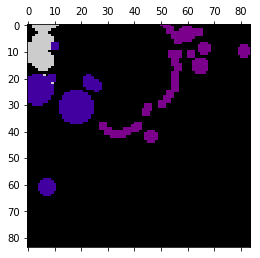

In [10]:
# The purple color dots are player1's units, blue violet color dots are player2's units, white dots are neutral resouces.

plt.matshow(csr_matrix((sparse_matrix_data, sparse_matrix_indices, sparse_matrix_indptr), shape=(84, 84)).toarray(),
            cmap=plt.get_cmap('nipy_spectral'))
plt.show()

In [11]:
# We can also visualize screen_player_id feature using matplotlib animation.

screen_player_id_data = screen_player_id[0::3]
screen_player_id_indices = screen_player_id[1::3]
screen_player_id_indptr = screen_player_id[2::3]

len(screen_player_id), len(screen_player_id_data), len(screen_player_id_indices), len(screen_player_id_indptr)

(3240, 1080, 1080, 1080)

<IPython.core.display.Javascript object>


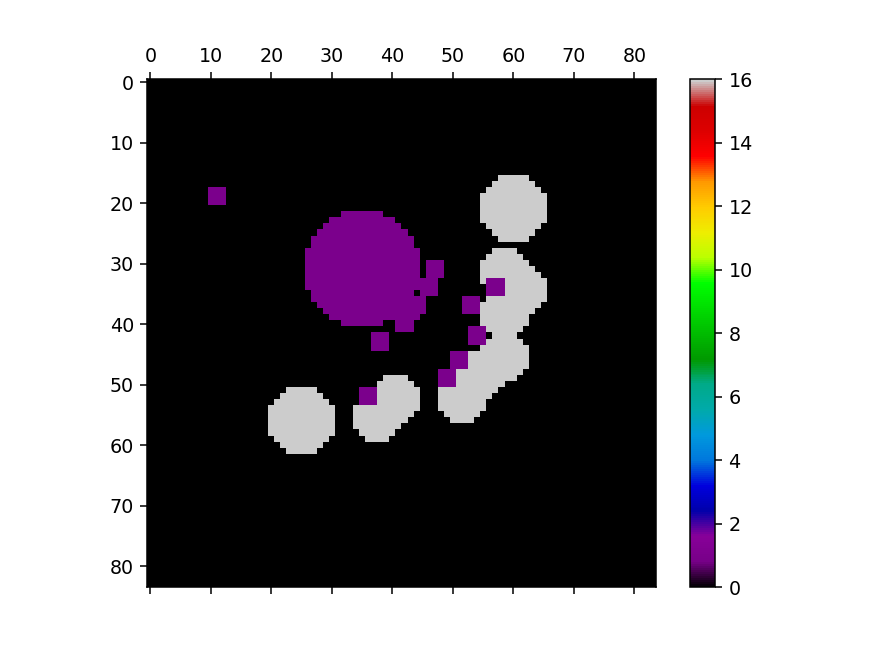

In [12]:
%matplotlib notebook

def transform_sparse_matrix(data, indices, indptr):
    sparse_data = [int(i) for i in data[:-1].split(',')]
    sparse_indices = [int(i) for i in indices[:-1].split(',')]
    sparse_indptr = [int(i) for i in indptr[:-1].split(',')]
    return sparse_data, sparse_indices, sparse_indptr

def update(i):
    mat.set_data(csr_matrix(transform_sparse_matrix(screen_player_id_data[i], screen_player_id_indices[i], 
                                                    screen_player_id_indptr[i]), shape=(84, 84)).toarray())
    return mat 

fig, ax = plt.subplots()
mat = ax.matshow(csr_matrix(transform_sparse_matrix(screen_player_id_data[0], screen_player_id_indices[0], 
                                                    screen_player_id_indptr[0]), shape=(84, 84)).toarray(), cmap=plt.get_cmap('nipy_spectral'))
plt.colorbar(mat)
ani = animation.FuncAnimation(fig, update, frames=len(screen_player_id_data), interval=50)
plt.show()